# Generalized Linear Modeling with PyGLM

In [1]:
# !pip install git+https://github.com/cscherrer/py-glm.git

from glm.glm import GLM
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Here's some data for coal mining disasters:

In [2]:
y = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
     3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
     2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
     1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
     0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
     3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
     0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

x = np.arange(1851, 1962)

mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

In [7]:
## This is COUNT DATA! Therefore, you use a POISSON Regression for this.
# Poisson is designed specifically for COUNT DATA

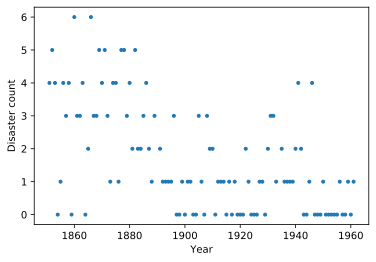

In [3]:
plt.plot(x,y, '.');
plt.ylabel("Disaster count")
plt.xlabel("Year");

Did the accident rate change over time? Let's use Poisson regression to investigate.

In [5]:
from glm.families import Poisson              # Poisson Regression!
poissonReg = GLM(family=Poisson())

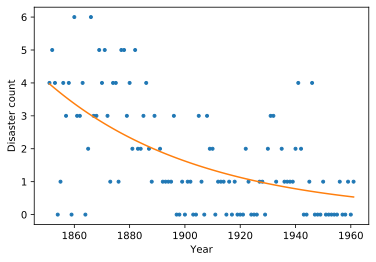

In [6]:
X = np.c_[np.ones_like(y),x]
poissonReg.fit(X,y) # Fit your possion regression
yhat = poissonReg.predict(X) # Make predictions
residuals = poissonReg.deviance_residuals(X,y)  # obtain your residuals

plt.plot(x,y, '.');
plt.plot(x,yhat)
plt.ylabel("Disaster count")
plt.xlabel("Year");

PyGLM gives us the $p$-values for free:

In [ ]:
poissonReg.p_values_

But we could also calculate this. Say we have a model $\mathcal{M}_1$ with $p_1$ parameters and a submodel $\mathcal{M}_0$ with $p_0$ parameters. Then under the null hypothesis ($H_0$: Data follow $M_0$), the difference in deviance is asymptotically ("given enough data") distributed as a $\chi^2$ with $\Delta p = p_1 - p_0$ degrees of freedom.

In [ ]:
m0 = poissonReg.clone()
m0.fit(np.ones_like(y).reshape(-1,1),y)
m0.deviance_

In [ ]:
poissonReg.deviance_

In [ ]:
from scipy.stats import chi2
1 - chi2(1).cdf(m0.deviance_ - poissonReg.deviance_)

This is quite a bit different than the value we saw above, because PyGLM uses a [_Wald test_](https://en.wikipedia.org/wiki/Wald_test), while the result we described above uses [_Wilks' theorem_](https://en.wikipedia.org/wiki/Wilks%27_theorem). These are both asymptotic tests, and should give very similar results (or at least similar _conclusions_) in most cases.

Now let's take a look at the deviance residuals. The `myPlot` code below uses _generalized additive models_ to make it easier to see any trends in the residuals.

In [ ]:
# !conda install -c conda-forge scikit-sparse nose
# !pip install pygam

from pygam import ExpectileGAM

def myPlot(m, x,y):
    X = np.c_[np.ones_like(y),x]
    gam50 = ExpectileGAM(expectile=0.5).gridsearch(X, y)

    # and copy the smoothing to the other models
    lam = gam50.lam

    # now fit a few more models
    gam95 = ExpectileGAM(expectile=0.95, lam=lam).fit(X, y)
    gam75 = ExpectileGAM(expectile=0.75, lam=lam).fit(X, y)
    gam25 = ExpectileGAM(expectile=0.25, lam=lam).fit(X, y)
    gam05 = ExpectileGAM(expectile=0.05, lam=lam).fit(X, y)


    plt.plot(x,y,'.')
    plt.plot(x,gam50.predict(X))
    plt.fill_between(x,gam05.predict(X),gam95.predict(X),color='C1',alpha=0.1)
    plt.fill_between(x,gam25.predict(X),gam75.predict(X),color='C1',alpha=0.3)

With `myPlot` defined, we can have a look at the deviance residuals:

In [ ]:
myPlot(poissonReg,x,residuals)
plt.xlabel("Year")
plt.ylabel("Deviance Residual")
plt.hlines(0,np.min(x),np.max(x));

That's some strong variability, so we're probably missing a feature. Let's try adding a _change point_, a feature of the form `x > k`. This will allow for a "break" in the plot to account for some drmamatic change (maybe OSHA regulations?).

But where should we put the change point? It's not obvious, but looks like in should be somewhere in the 1880-1940 range. Let's try the possibilities and see which gives us the best deviance:

In [ ]:
years = range(1880,1940)

# Pre-allocate an array to populate in the loop. 
# For larger arrays, this can help performance a lot, so it's a good habit :)
deviances = np.zeros_like(years)

for j,changept in enumerate(years):
    newX = np.c_[np.ones_like(x),x, x>changept]
    poissonReg.fit(newX,y)
    deviances[j] = poissonReg.deviance_

In [ ]:
plt.plot(years,deviances);
plt.xlabel('Year')
plt.ylabel('Deviance');

In [ ]:
X = np.c_[np.ones_like(x),x, x>1891]

poissonReg.fit(X,y)
residuals=poissonReg.deviance_residuals(X,y)

Did that help? Let's check it out:

In [ ]:
myPlot(poissonReg,x,residuals)
plt.hlines(0,np.min(x),np.max(x))
plt.xlabel('Year')
plt.ylabel('Deviance Residual')

In [ ]:
poissonReg.fit(X,y)
yhat = poissonReg.predict(X)
residuals = poissonReg.deviance_residuals(X,y)

plt.plot(x,y, '.');
plt.plot(x,yhat)
plt.ylabel("Disaster count")
plt.xlabel("Year");

## `Simulation`: Bootstrapping GLM Models

In an earlier lecture, we saw bootstrapping as the first ingredient in bagging. More specifically, that was a _nonparametric_ bootstrap. PyGLM gives us a way to so this easily for a given model. First we build a `Simulation` object:

In [ ]:
from glm.simulation import Simulation
sim = Simulation(poissonReg)

Next, the general structure is

```python
for m in sim.non_parametric_bootstrap(X,y):
    # Do something with `m`
```

Maybe the simplest thing we could do is to just plot the results:

In [ ]:
plt.plot(x,y, '.');
plt.plot(x,yhat)
plt.ylabel("Disaster count")
plt.xlabel("Year");
for m in sim.non_parametric_bootstrap(X,y):
    plt.plot(x,m.predict(X),c='C1',alpha=0.02,lw=4)

The bootstrap tells us what kind of behavior we can expect on data simulated in the same way. We can think of the results as "possible worlds". This gives us some insight into variability and the plausibility of simpler models.

For example, look at the years before the changepoint. The bootstrap results tell us that this segment suffers from much higher variance than that after the changepoint. Maybe we can constrain things to improve this. 

Luckily, there's an obvious path; a "constant on each segment" model is well within range. This is supported by the $p$-values:

In [ ]:
poissonReg.p_values_

That 0.353 is way out of line; let's get rid of it and check again.

In [ ]:
X = np.c_[np.ones_like(x), x>1890]

poissonReg.fit(X,y)
yhat = poissonReg.predict(X)

residuals=poissonReg.deviance_residuals(X,y)

In [ ]:
plt.plot(x,y, '.');
plt.plot(x,yhat)
plt.ylabel("Disaster count")
plt.xlabel("Year");
for m in sim.non_parametric_bootstrap(X,y):
    plt.plot(x,m.predict(X),c='C1',alpha=0.01,lw=4)

And just to make sure we didn't screw up the residuals...

In [ ]:
myPlot(poissonReg,x,residuals)
plt.hlines(0,np.min(x),np.max(x))
plt.xlabel('Year')
plt.ylabel('Deviance Residual')

## Other Consderations

A $\text{Poisson}(\lambda)$ distribution has mean $\lambda$ and also variance $\lambda$. Sometimes we need higher variance (due to additional sources of noise, etc). This can be done with a _dispersion_ parameter included in the `QuasiPoisson` family (`Poisson` constrains dispersion to equal one). It's also common to use a `NegativeBinomial` for this, but the effect can be very different.

Counts usually count events in some time period, but the "exposure" durations may be be uniform. This can be expressed by adding an `offset` keyword argument to the `.fit` method.